# Overview

This notebook shows how to define a kernel that is robust to uncalibrated data in the input dimension.

In [11]:
import matplotlib.pyplot as plt

import torch
from botorch.models import MultiTaskGP
from botorch.fit import fit_gpytorch_mll
from gpytorch.mlls import ExactMarginalLogLikelihood

In [12]:
def plot_gp(gp, X, y):
    x = torch.linspace(0, 1, 200).reshape(-1,1)
    with torch.no_grad():
        p = gp.posterior(x)

        #get the mean
        m = p.mean

        #get the 2 sigma confidence region around the mean
        l,u = p.mvn.confidence_region()

    plt.figure()

    plt.ylabel('$f$')

    plt.fill_between(x.squeeze(), l[:,1], u[:,1], alpha = 0.25, lw = 0, color='C0')

    plt.scatter(X[:,0][X[:,1]==0], y[X[:,1]==0], color='C1', label='Low-fidelity data')
    plt.scatter(X[:,0][X[:,1]==1], y[X[:,1]==1], color='C0', label='High-fidelity data')
    plt.plot(x, m[:,1], color='C0', lw=1, label='Multi-fidelity GP prediction\n for high-fidelity data')

    plt.legend(loc=0, fontsize='small')
    plt.xlim(0, 1)
    plt.xticks([])
    plt.ylim(-2, 5)

    # Extract correlation coefficient
    cov = gp.task_covar_module._eval_covar_matrix()
    corr = cov[1,0]/torch.sqrt(cov[0,0]*cov[1,1]).item()
    plt.title( f'Correlation coefficient: {corr:.2f}' )

## Robustness to wrong calibration in output

The multifidelity kernel is naturally robust to mismatch between the two fidelities in the output dimension.

In [13]:
# Define synthetic data
# The low-fidelity data is wrongfully calibrated: vertical shift + negative correlation

X1 = torch.tensor([0.03, 0.1, 0.15, 0.17, 0.6, 0.68, 0.7, 0.8, 0.82, 0.95]).to(dtype=torch.float64)
X1 = torch.stack([X1, torch.zeros_like(X1)],dim=-1)
X2 = torch.tensor([0.03, 0.1, 0.14, 0.2, 0.3, 0.97]).to(dtype=torch.float64)
X2 = torch.stack([X2, torch.ones_like(X2)],dim=-1)
X = torch.cat([X1, X2])
y = 0.2*(torch.rand(len(X),1)-0.5) + torch.sin(6*X[:,0:1])*(2-X[:,1:]) +0.5*(1-X[:,1:])

Calling fit_gpytorch_mll
Calling _fit_fallback
optimizer: <function fit_gpytorch_mll_scipy at 0x161e9da80>
closure: None
reducer <method 'sum' of 'torch._C.TensorBase' objects>
closure: <botorch.optim.closures.core.ForwardBackwardClosure object at 0x16669a8a0>
attempt 1
method: L-BFGS-B
options None
x0 None
Calling fit_gpytorch_mll
Calling _fit_fallback
optimizer: <function fit_gpytorch_mll_scipy at 0x161e9da80>
closure: None
reducer <method 'sum' of 'torch._C.TensorBase' objects>
closure: <botorch.optim.closures.core.ForwardBackwardClosure object at 0x166699a90>
attempt 1
method: L-BFGS-B
options None
x0 None
Calling fit_gpytorch_mll
Calling _fit_fallback
optimizer: <function fit_gpytorch_mll_scipy at 0x161e9da80>
closure: None
reducer <method 'sum' of 'torch._C.TensorBase' objects>
closure: <botorch.optim.closures.core.ForwardBackwardClosure object at 0x166922f90>
attempt 1
method: L-BFGS-B
options None
x0 None


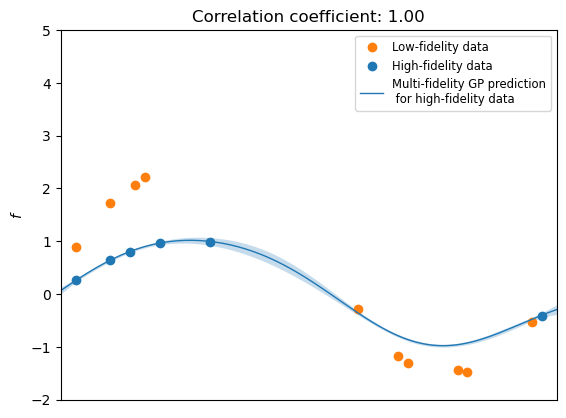

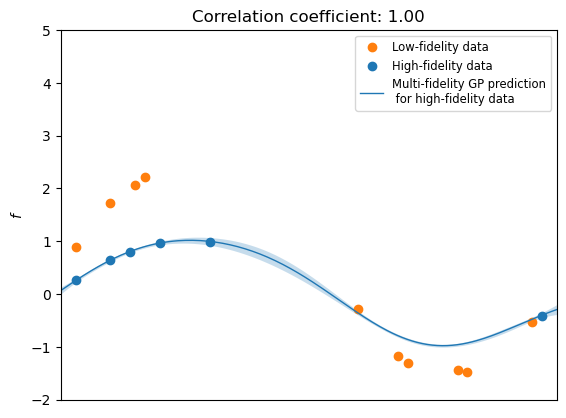

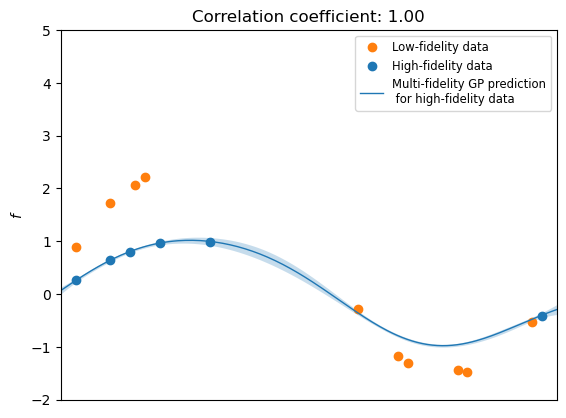

In [14]:
# Train and plot GP (do 3 different training to check for robustness)
for _ in range(3):
    gp = MultiTaskGP(X, y, task_feature=-1, rank=2)
    mll = ExactMarginalLogLikelihood(gp.likelihood, gp)
    fit_gpytorch_mll(mll);

    plot_gp(gp, X, y)


## Non-robustness to wrong calibration in input

In [15]:
# Define synthetic data
# The low-fidelity data is wrongfully calibrated: horizontal shift

X1 = torch.tensor([0.1, 0.15, 0.17, 0.27, 0.3, 0.35, 0.4, 0.5, 0.6, 0.68, 0.7, 0.8, 0.82, 0.95]).to(dtype=torch.float64)
X1 = torch.stack([X1, torch.zeros_like(X1)],dim=-1)
X2 = torch.tensor([0.03, 0.1, 0.14, 0.2, 0.3, 0.97]).to(dtype=torch.float64)
X2 = torch.stack([X2, torch.ones_like(X2)],dim=-1)
X = torch.cat([X1, X2])
y = 0.2*(torch.rand(len(X),1)-0.5) + torch.sin(6*X[:,0:1]- 1.5*(1-X[:,1:]) )

Calling fit_gpytorch_mll
Calling _fit_fallback
optimizer: <function fit_gpytorch_mll_scipy at 0x161e9da80>
closure: None
reducer <method 'sum' of 'torch._C.TensorBase' objects>
closure: <botorch.optim.closures.core.ForwardBackwardClosure object at 0x16661b4d0>
attempt 1
method: L-BFGS-B
options None
x0 None
Calling fit_gpytorch_mll
Calling _fit_fallback
optimizer: <function fit_gpytorch_mll_scipy at 0x161e9da80>
closure: None
reducer <method 'sum' of 'torch._C.TensorBase' objects>
closure: <botorch.optim.closures.core.ForwardBackwardClosure object at 0x1640d7a00>
attempt 1
method: L-BFGS-B
options None
x0 None
Calling fit_gpytorch_mll
Calling _fit_fallback
optimizer: <function fit_gpytorch_mll_scipy at 0x161e9da80>
closure: None
reducer <method 'sum' of 'torch._C.TensorBase' objects>
closure: <botorch.optim.closures.core.ForwardBackwardClosure object at 0x1666beb10>
attempt 1
method: L-BFGS-B
options None
x0 None


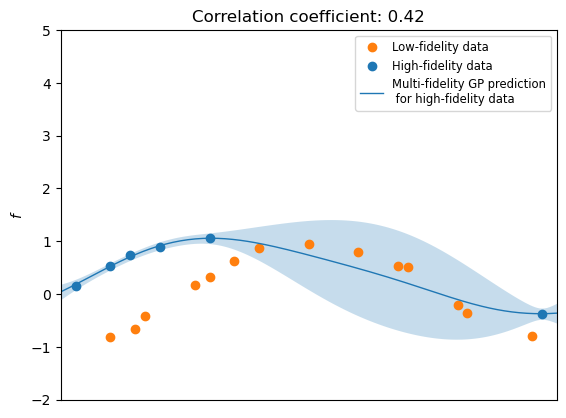

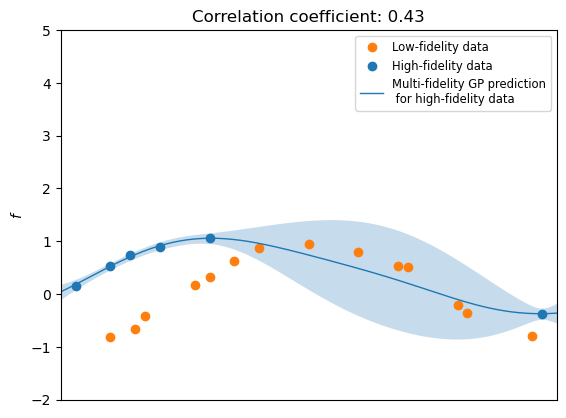

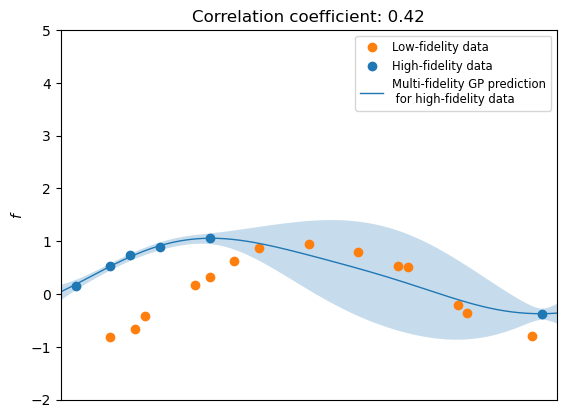

In [16]:
# Train and plot GP (do 3 different training to check for robustness)
for _ in range(3):
    gp = MultiTaskGP(X, y, task_feature=-1, rank=2)
    mll = ExactMarginalLogLikelihood(gp.likelihood, gp)
    fit_gpytorch_mll(mll);

    plot_gp(gp, X, y)


In [17]:
# New hyperparameters; note that the phase has been optimized
for p in gp.named_parameters():
    print(p)
    print('')

('likelihood.noise_covar.raw_noise', Parameter containing:
tensor([0.0073], dtype=torch.float64, requires_grad=True))

('mean_module.raw_constant', Parameter containing:
tensor(-0.2769, dtype=torch.float64, requires_grad=True))

('covar_module.raw_lengthscale', Parameter containing:
tensor([[0.2140]], dtype=torch.float64, requires_grad=True))

('task_covar_module.covar_factor', Parameter containing:
tensor([[0.7773, 0.4987],
        [0.5480, 0.2030]], dtype=torch.float64, requires_grad=True))

('task_covar_module.raw_var', Parameter containing:
tensor([ 0.0920, -0.1425], dtype=torch.float64, requires_grad=True))



# Define a kernel that is robust to horizontal shift

The idea is to implement a kernel of the form:
$$k[(s, \boldsymbol{x}), (s', \boldsymbol{x'})] = \tilde{\kappa}_{s,s'}\kappa(\boldsymbol{x}-\boldsymbol{x'}-\Delta \boldsymbol{x}_{s, s'})$$

where $\Delta \boldsymbol{x}_{s, s'}$ is a hyperparameter such that:
- $\Delta \boldsymbol{x}_{s, s'} = 0$ if $s=s'$
- $ \Delta \boldsymbol{x}_{s, s'} = - \Delta \boldsymbol{x}_{s', s}$

### notes on implementation

- `MultiTaskGP` is defined in `botorch/models/multitask.py`

    From the documentation

    - WARNING: This currently does not support different noise levels for the different tasks.
    - `covar_module`: The module for computing the covariance matrix between the non-task features. Defaults to `RBFKernel`.
    - `rank`: The rank to be used for the index kernel. If omitted, use a full rank (i.e. number of tasks) kernel.

    Key line: 
    `self.task_covar_module = IndexKernel(num_tasks=self.num_tasks, rank=self._rank, prior=task_covar_prior)`
    Note: This subclasses `MultiTaskGP` and redefine its `forward` method; can we instead target the `input_transform`?
    - Should we subclass `MultiTaskGP` and redefine its `forward` method
    - What is `MultitaskKernel`?
    - Try in a 2D example + with real data

- How to add priors on the values of the shift?
- How to add task-dependent noise?

In [18]:
from torch import Tensor
from gpytorch.distributions.multivariate_normal import MultivariateNormal
from gpytorch.module import Module
from botorch.models.transforms.input import InputTransform
from botorch.models.transforms.outcome import OutcomeTransform
from botorch.utils.types import _DefaultType, DEFAULT
from gpytorch.likelihoods.likelihood import Likelihood
from gpytorch.priors.prior import Prior

class ShiftedMultiTaskGP(MultiTaskGP):
    """Multi-task GP with task-specific input shifts.

    This model extends MultiTaskGP by adding task-specific shift parameters
    Δx_{s,s'} to the kernel, resulting in a kernel of the form:
    k[(s,x), (s',x')] = κ_{s,s'} * k(x - x' - Δx_{s,s'})

    where κ_{s,s'} is the task covariance and k is the base kernel.
    """

    def __init__(
        self,
        train_X: Tensor,
        train_Y: Tensor,
        task_feature: int,
        train_Yvar: Tensor | None = None,
        mean_module: Module | None = None,
        covar_module: Module | None = None,
        likelihood: Likelihood | None = None,
        task_covar_prior: Prior | None = None,
        output_tasks: list[int] | None = None,
        rank: int | None = None,
        all_tasks: list[int] | None = None,
        outcome_transform: OutcomeTransform | _DefaultType | None = DEFAULT,
        input_transform: InputTransform | None = None,
    ) -> None:
        super().__init__(
            train_X=train_X,
            train_Y=train_Y,
            task_feature=task_feature,
            train_Yvar=train_Yvar,
            mean_module=mean_module,
            covar_module=covar_module,
            likelihood=likelihood,
            task_covar_prior=task_covar_prior,
            output_tasks=output_tasks,
            rank=rank,
            all_tasks=all_tasks,
            outcome_transform=outcome_transform,
            input_transform=input_transform,
        )
        # Initialize task-specific shifts
        self.input_dim = train_X.shape[-1] - 1  # Subtract task feature
        self.register_parameter(name="shifts", parameter=torch.nn.Parameter(torch.zeros(self.num_tasks, self.input_dim)))

    def forward(self, x: Tensor) -> MultivariateNormal:
        if self.training:
            x = self.transform_inputs(x)
        x_basic, task_idcs = self._split_inputs(x)
        # Apply shifts
        shifts = self.shifts[task_idcs.reshape(-1)]
        x_basic = x_basic - shifts
        # Compute base mean and covariance
        mean_x = self.mean_module(x_basic)
        covar_x = self.covar_module(x_basic)
        # Compute task covariances
        covar_i = self.task_covar_module(task_idcs)
        # Combine the two in an ICM fashion
        covar = covar_x.mul(covar_i)
        return MultivariateNormal(mean_x, covar)


In [19]:
gp = ShiftedMultiTaskGP(X, y, task_feature=-1, rank=2)
mll = ExactMarginalLogLikelihood(gp.likelihood, gp)
fit_gpytorch_mll(mll);
for p in gp.named_parameters():
    print(p)


Calling fit_gpytorch_mll
Calling _fit_fallback
optimizer: <function fit_gpytorch_mll_scipy at 0x161e9da80>
closure: None
reducer <method 'sum' of 'torch._C.TensorBase' objects>
closure: <botorch.optim.closures.core.ForwardBackwardClosure object at 0x1667f5b50>
attempt 1
method: L-BFGS-B
options None
x0 None
('shifts', Parameter containing:
tensor([[ 0.1154],
        [-0.1150]], requires_grad=True))
('likelihood.noise_covar.raw_noise', Parameter containing:
tensor([0.0068], dtype=torch.float64, requires_grad=True))
('mean_module.raw_constant', Parameter containing:
tensor(-0.8086, dtype=torch.float64, requires_grad=True))
('covar_module.raw_lengthscale', Parameter containing:
tensor([[0.2280]], dtype=torch.float64, requires_grad=True))
('task_covar_module.covar_factor', Parameter containing:
tensor([[0.0548, 1.1791],
        [0.0569, 1.2249]], dtype=torch.float64, requires_grad=True))
('task_covar_module.raw_var', Parameter containing:
tensor([-14.5840, -20.6140], dtype=torch.float64, r

Calling fit_gpytorch_mll
Calling _fit_fallback
optimizer: <function fit_gpytorch_mll_scipy at 0x161e9da80>
closure: None
reducer <method 'sum' of 'torch._C.TensorBase' objects>
closure: <botorch.optim.closures.core.ForwardBackwardClosure object at 0x166625020>
attempt 1
method: L-BFGS-B
options None
x0 None
Calling fit_gpytorch_mll
Calling _fit_fallback
optimizer: <function fit_gpytorch_mll_scipy at 0x161e9da80>
closure: None
reducer <method 'sum' of 'torch._C.TensorBase' objects>
closure: <botorch.optim.closures.core.ForwardBackwardClosure object at 0x166626360>
attempt 1
method: L-BFGS-B
options None
x0 None
Calling fit_gpytorch_mll
Calling _fit_fallback
optimizer: <function fit_gpytorch_mll_scipy at 0x161e9da80>
closure: None
reducer <method 'sum' of 'torch._C.TensorBase' objects>
closure: <botorch.optim.closures.core.ForwardBackwardClosure object at 0x166aa5b30>
attempt 1
method: L-BFGS-B
options None
x0 None


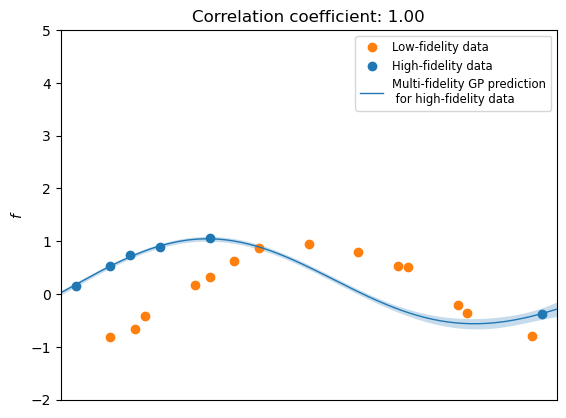

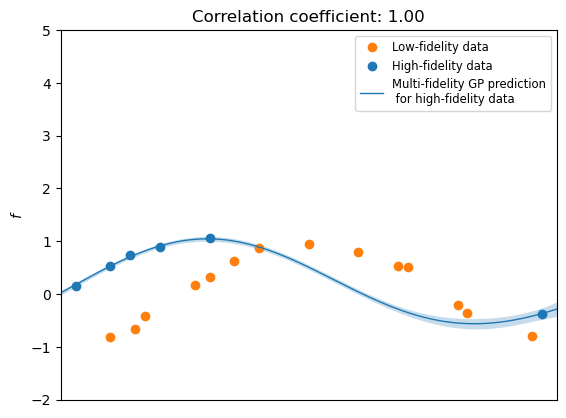

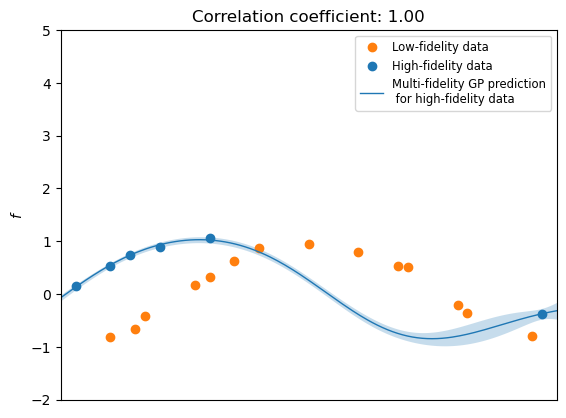

In [20]:
# Train and plot GP (do 3 different training to check for robustness)
for _ in range(3):
    gp = ShiftedMultiTaskGP(X, y, task_feature=-1, rank=2)
    mll = ExactMarginalLogLikelihood(gp.likelihood, gp)
    fit_gpytorch_mll(mll);

    plot_gp(gp, X, y)